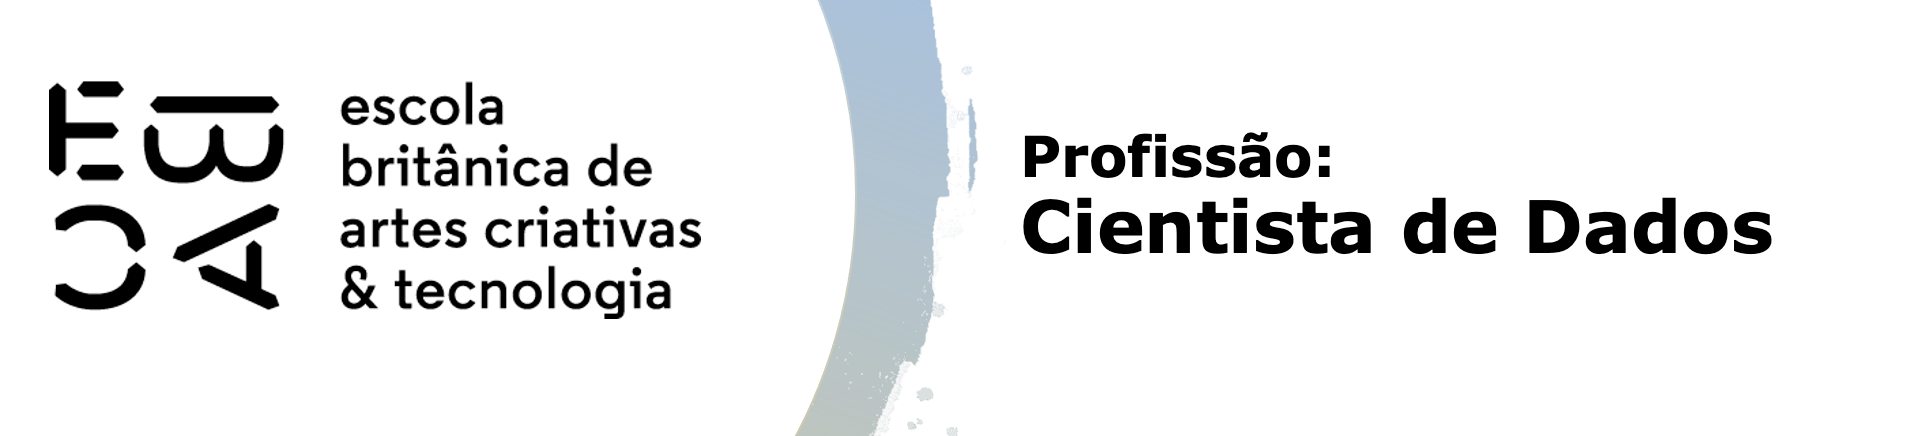

# Análise de *Clusters*

## Aplicação

Nesta demonstração vamos aplicar o K-Means na based de dados de "*Human Activity Recognition using Smartphones*", disponível no [UCI](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones) (repositório de bases de dados para *Machine Learning* da Universidade de Irvine.

## Fluxo de projeto

Lembre-se do [CRISP-DM](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining). Ao discutir o algoritmo estamos nos concentrando em uma parte específica do fluxo de um projeto enorme, mas essa parte depende fortemente do entendimento do negócio.

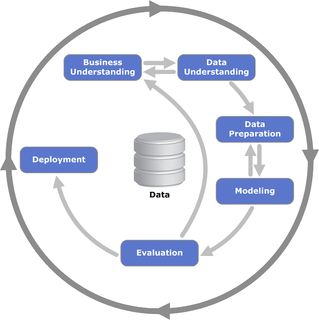

Métodos de agrupamento trazem uma carga subjetiva bem maior que métodos de classificação como árvores de decisão e *random forest*, e o entendimento do negócio tem um papel crucial aqui. Ao decidir que variáveis entram no modelo estamos interferindo fortemente nos resultados, e essa decisão deve depender do objetivo do negócio. Por exemplo, se o objetivo é entender padrões de consumo, tipicamente variáveis biométricas ou financeiras do cliente não devem ser relevantes. Por outro lado, se estamos estudando o desempenho de atletas, talvez a prioridade seja diferente.

**O nosso objetivo** é verificar se encontramos padrões de movimentação que definam bem grupos de observações semelhantes entre si e diferentes entre si, depois vamos tentar interpretar estes grupos.

Para isso vamos fazer uma seleção de variáveis (*feature selection*) com ideias bem simples, porém usando um pouco a criatividade para estarmos conectados aos objetivos iniciais. Esteja sempre conectado ao objetivo inicial!

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:



filename_features = "../Dados/UCI HAR Dataset/features.txt"
filename_labels = "../Dados/UCI HAR Dataset/activity_labels.txt"

filename_subtrain = "../Dados/UCI HAR Dataset/train/subject_train.txt"
filename_xtrain = "../Dados/UCI HAR Dataset/train/X_train.txt"
filename_ytrain = "../Dados/UCI HAR Dataset/train/y_train.txt"

filename_subtest = "../Dados/UCI HAR Dataset/test/subject_test.txt"
ffilename_xtest = "../Dados/UCI HAR Dataset/test/X_test.txt"
filename_ytest = "../Dados/UCI HAR Dataset/test/y_test.txt"

features = pd.read_csv(filename_features, header=None, names=['nome_var'], squeeze=True, sep="#")
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'], squeeze=True)
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'], squeeze=True)
X_test = pd.read_csv(ffilename_xtest, delim_whitespace=True, header=None, names=features.tolist())
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

X_train.to_feather('X_train.ftr')
y_train.to_feather('y_train.ftr')
X_test.to_feather('X_test.ftr')
y_test.to_feather('X_test.ftr')
labels.to_feather('labels.ftr')

In [3]:
X_train = pd.read_feather('X_train.ftr')
y_train = pd.read_feather('y_train.ftr')
X_test = pd.read_feather('X_test.ftr')
y_test = pd.read_feather('X_test.ftr')
labels = pd.read_feather('labels.ftr')

y_train_cat = pd.Categorical.from_codes(codes=(y_train-1).values.flatten(),categories= labels.label)
y_train_cat.value_counts()

WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
SITTING               1286
STANDING              1374
LAYING                1407
dtype: int64

In [4]:
X_test.columns

Index(['cod_label'], dtype='object')

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


X_pad = StandardScaler().fit_transform(X_train)

pca_train = PCA().fit(X_pad)

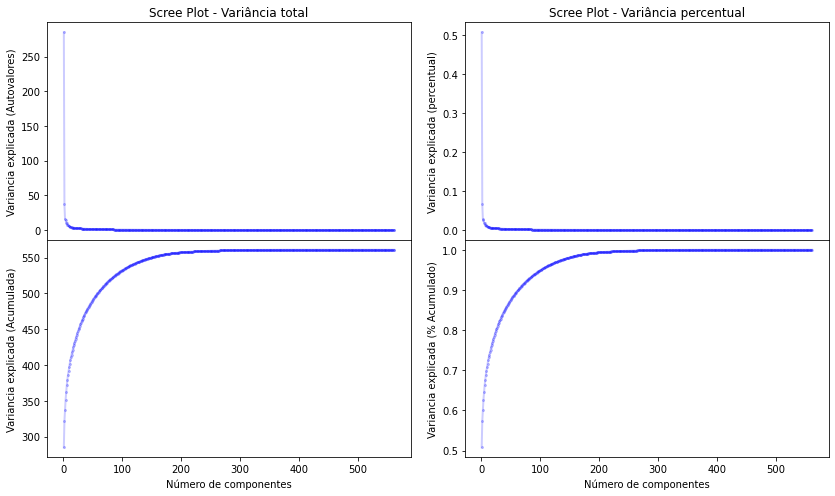

In [11]:
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

def screeplot(pca):
    ampli_y1 = pca.explained_variance_[0]

    num_componentes = np.arange(pca.n_components_) + 1
    ax[0,0].plot(num_componentes, pca.explained_variance_, 
                 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
    ax[0,0].set_title('Scree Plot - Variância total')
    ax[0,0].set_xlabel('Número de componentes')
    ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

    ax[1,0].plot(num_componentes, pca.explained_variance_.cumsum(), 
                 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
    ax[1,0].set_xlabel('Número de componentes')
    ax[1,0].set_ylabel('Variancia explicada (Acumulada)')


    ampli_y2 = pca.explained_variance_ratio_[0]
    # ax[1].set_ylim(-ampli_y2*.05, ampli_y2*1.1)

    ax[0,1].plot(num_componentes, pca.explained_variance_ratio_, 
                 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
    ax[0,1].set_title('Scree Plot - Variância percentual')
    ax[0,1].set_xlabel('Número de componentes')
    ax[0,1].set_ylabel('Variancia explicada (percentual)')

    ax[1,1].plot(num_componentes, pca.explained_variance_ratio_.cumsum(), 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
    ax[1,1].set_xlabel('Número de componentes')
    ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

    plt.show()

screeplot(pca_train)

In [7]:
y_train.shape

(7352, 1)

In [ ]:
(y_train-1).value_counts(dropna=False)

In [ ]:
(y_train-1).values.flatten()

In [12]:
X_pad = pd.DataFrame(X_pad, columns = X_train.columns)
X_pad['y'] = y_train_cat
std_por_grupo = X_pad.groupby('y').std()
med_por_grupo = X_pad.groupby('y').median()

colunas = std_por_grupo.idxmax(axis=1).values

colunas

array(['477 fBodyGyro-bandsEnergy()-17,24',
       '489 fBodyGyro-bandsEnergy()-1,8',
       '479 fBodyGyro-bandsEnergy()-33,40', '291 fBodyAcc-maxInds-X',
       '291 fBodyAcc-maxInds-X', '44 tGravityAcc-std()-X'], dtype=object)

<AxesSubplot:ylabel='Frequency'>

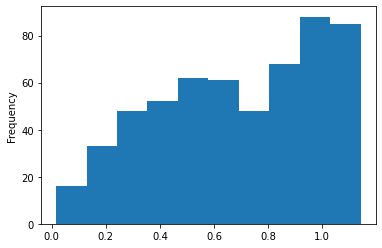

In [18]:
med_por_grupo.std().plot.hist()

In [19]:
std_por_grupo.std().sort_values().tail()

485 fBodyGyro-bandsEnergy()-33,48       0.820481
478 fBodyGyro-bandsEnergy()-25,32       0.823670
417 fBodyAccJerk-bandsEnergy()-57,64    0.823937
479 fBodyGyro-bandsEnergy()-33,40       0.846680
389 fBodyAccJerk-bandsEnergy()-57,64    0.851279
dtype: float64

In [20]:
colunas = med_por_grupo.abs().idxmax(axis=1).values
colunas

array(['349 fBodyAccJerk-std()-Y', '370 fBodyAccJerk-maxInds-X',
       '509 fBodyAccMag-energy()', '78 tGravityAcc-correlation()-X,Y',
       '297 fBodyAcc-skewness()-X', '57 tGravityAcc-energy()-X'],
      dtype=object)

In [21]:
med_por_grupo[colunas]

,349 fBodyAccJerk-std()-Y,370 fBodyAccJerk-maxInds-X,509 fBodyAccMag-energy(),"78 tGravityAcc-correlation()-X,Y",297 fBodyAcc-skewness()-X,57 tGravityAcc-energy()-X
y,,,,,,
WALKING,1.202232,-0.054779,0.173209,0.126327,-0.032826,0.587410
WALKING_UPSTAIRS,0.531527,-1.279263,0.438330,0.656643,0.654751,0.394938
WALKING_DOWNSTAIRS,1.166609,-1.279263,1.887126,0.321926,0.370770,0.544520
SITTING,-0.856693,0.679912,-0.711657,-1.284109,-0.863811,0.523054
STANDING,-0.848196,0.679912,-0.711024,0.742047,-1.052473,0.625828
LAYING,-0.859069,0.435015,-0.711078,0.487033,0.275065,-2.015754


In [22]:
colunas2 = list(colunas) + ['y']
colunas2

['349 fBodyAccJerk-std()-Y',
 '370 fBodyAccJerk-maxInds-X',
 '509 fBodyAccMag-energy()',
 '78 tGravityAcc-correlation()-X,Y',
 '297 fBodyAcc-skewness()-X',
 '57 tGravityAcc-energy()-X',
 'y']

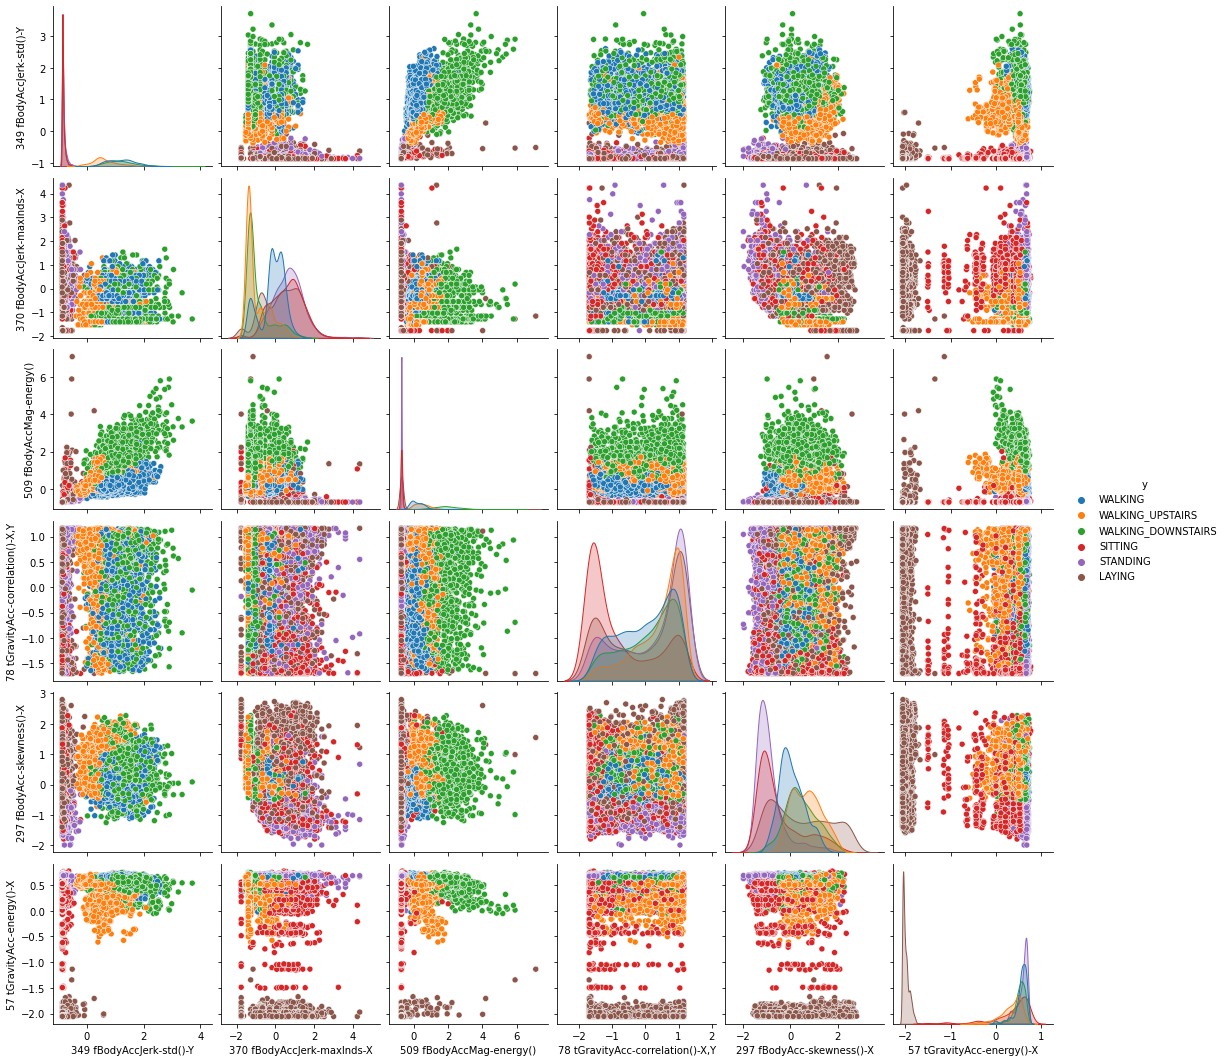

In [23]:
sns.pairplot(X_pad[colunas2], hue='y')

In [24]:
cluster = KMeans(n_clusters=6)
cluster.fit_predict(X_pad[colunas])

array([3, 2, 2, ..., 1, 1, 1], dtype=int32)

In [25]:
cluster.labels_

array([3, 2, 2, ..., 1, 1, 1], dtype=int32)

In [26]:
X_pad['grupos'] = pd.Categorical(cluster.labels_)
colunas3 = list(colunas) + ['grupos']

In [ ]:
sns.pairplot(X_pad[colunas3], hue='grupos')

In [ ]:
labels

In [ ]:
pd.crosstab(X_pad.y, X_pad.grupos)

In [ ]:
def dataviz_grupos(varx):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

    sns.boxplot(data=X_pad, y='grupos', x=varx, ax=ax[0])
    sns.boxplot(data=X_pad, y='y', x=varx, ax=ax[1])
    plt.show()

dataviz_grupos(colunas[5])

In [ ]:
labels.iloc[0,1]

In [ ]:
y_train.head()

In [ ]:
X_pad.y.cat.codes

In [ ]:
X_pad.loc[X_pad.y.cat.codes == 0,colunas[0]]

In [ ]:
from scipy.stats import ttest_ind

ttest_ind(X_pad.loc[X_pad.y.cat.codes == 0,colunas[0]], 
          X_pad.loc[X_pad.y.cat.codes != 0,colunas[0]])[0]

In [ ]:
estatisticas_t = med_por_grupo.copy()
estatisticas_t.loc[:,:] = 0
estatisticas_t

In [ ]:
X_pad.y == X_pad.y.unique()[0]

In [ ]:
for var in [estatisticas_t.columns]:
    for grupo in X_pad.y.unique():
        estatisticas_t.loc[grupo, var] = ttest_ind(X_pad.loc[X_pad.y == grupo, var], 
                                                   X_pad.loc[X_pad.y != grupo, var])[0]
 


In [ ]:
colunas_tt = estatisticas_t.abs().idxmax(axis=1).values
colunas_tt

In [ ]:
colunas_tt

In [ ]:
cluster.fit_predict(X_pad[colunas_tt])
X_pad['grupos2'] = pd.Categorical(cluster.labels_)
colunas4 = list(colunas) + ['grupos2']

In [ ]:
sns.pairplot(X_pad[colunas4], hue='grupos2')

In [ ]:
pd.crosstab(X_pad.y, X_pad.grupos2)

In [ ]:
def dataviz_grupos2(varx):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

    sns.boxplot(data=X_pad, y='grupos2', x=varx, ax=ax[0])
    sns.boxplot(data=X_pad, y='y', x=varx, ax=ax[1])
    plt.show()

In [ ]:
dataviz_grupos2(colunas_tt[3])